In [1]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import numpy as np

# set up initial path to data
DATADIR = 'data'
game_id = 2 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True, filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

Reading team: home
Reading team: away


In [2]:
events

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,-4.24,18.36,22.26,-17.68
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,20.14,-13.60,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,19.08,-13.60,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,16.96,-12.24,NaN,NaN


In [3]:
shots = events[events['Type'] == 'SHOT']
goals = shots[shots['Subtype'].str.contains('GOAL')].copy()

Let's focus on the second goal of the game 

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e9c4fe5b48>)

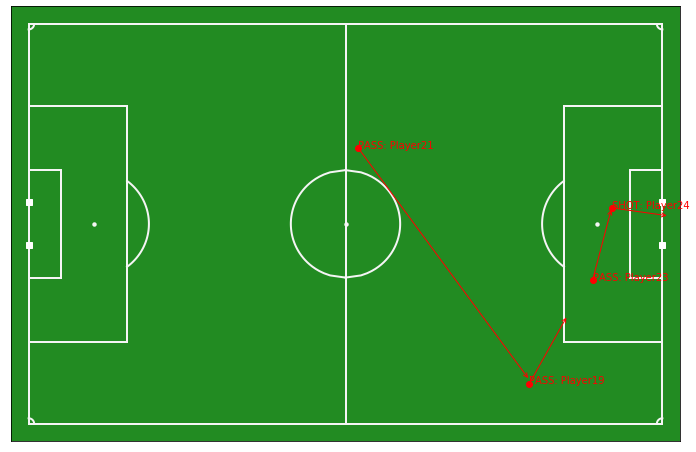

In [4]:
mviz.plot_events(events.loc[820:823],alpha =1 , annotate= True)

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e9c614c148>)

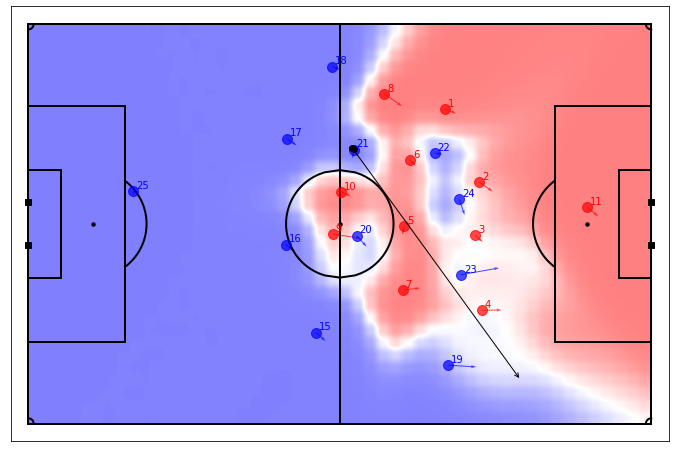

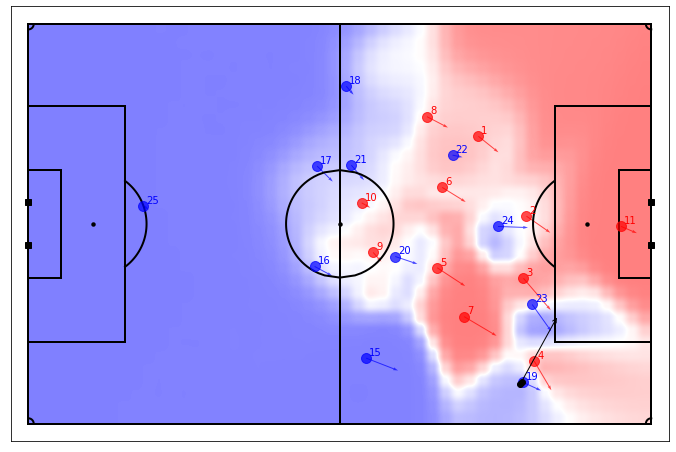

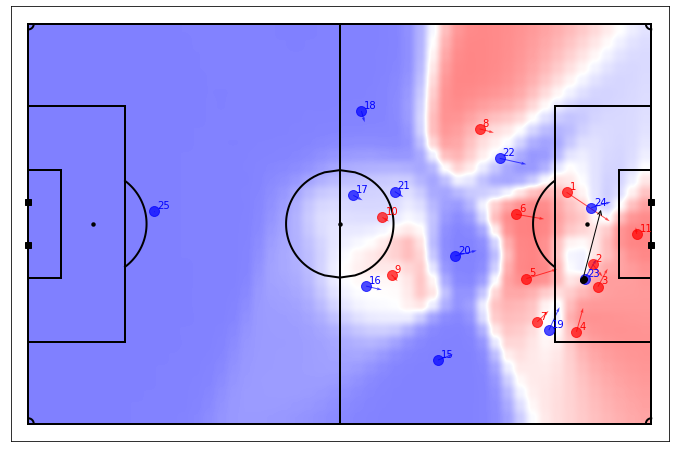

In [5]:
params = mpc.default_model_params(3)

# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(820, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 820, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )
# evaluated pitch control surface for second pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(821, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 821, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )
# evaluated pitch control surface for third pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(822, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 822, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )


In [6]:
""" **** calculate pass probability for every home team succesful pass **** """
# get all home passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]

In [7]:
# list for storing pass probablities
pass_success_probability = []

for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params)
    defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params)
    Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability.append( (i,Patt) )
    

Text(0, 0.5, 'Frequency')

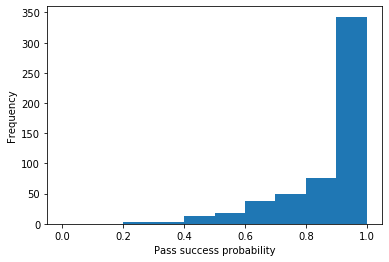

In [8]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  

In [9]:
# sort the passes by pitch control probability
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

In [10]:
# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e9c65e0b88>)

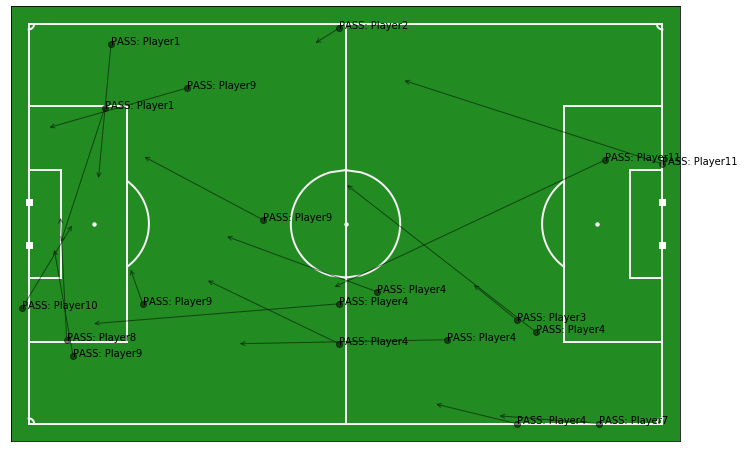

In [11]:
# plot the events
mviz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )

In [12]:
# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[ p[0]+1 ].Type
    print( p[1], outcome )

Event following a risky (completed) pass
0.26940888334951524 CHALLENGE
0.26977947525823215 SHOT
0.28355266004589275 BALL LOST
0.3118934257505092 CHALLENGE
0.33794938339419445 CHALLENGE
0.3882116886003005 SHOT
0.4120563552080869 CHALLENGE
0.4147820093582791 PASS
0.41861866721726027 PASS
0.4223978488361042 BALL LOST
0.431819076300889 CHALLENGE
0.44891911188416955 CHALLENGE
0.4610008848168425 CHALLENGE
0.46834301223806296 CHALLENGE
0.4687260445893318 SHOT
0.48894619695173597 CHALLENGE
0.4901175118019355 CHALLENGE
0.49387354493834146 SHOT
0.4985384467298248 PASS
0.5040960761022257 PASS


# Homework

- How might you use the pitch control model to calculate how much space was created (or territory captured) by an off the ball run?

    Hint: consider what the pitch control surface might have looked if the player had not made a run

For this question I will focus on the **off-side defenders movements**. How much is a movement that make the opponent off-side is valuable, even if it is only 1 or 2 meters.

In [13]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import numpy as np

# set up initial path to data
DATADIR = 'data'
game_id = 1 # let's look at sample match 1

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True, filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

Reading team: home
Reading team: away


To do so, I am going to look for a situation where a defender run 2 or three steps in order to put the opponent offside and what would have been the issue if he did not do the move.

Lets focus on the event of the only offside of the game:

In [15]:
events[events['Subtype'] == 'OFFSIDE']

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
403,Away,BALL LOST,OFFSIDE,1,29517,1180.68,29517,1180.68,Player18,NaN,-40.28,29.24,NaN,NaN


In [16]:
events.loc[399:403]

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
399,Away,RECOVERY,INTERCEPTION,1,29301,1172.04,29301,1172.04,Player18,NaN,-19.08,26.52,NaN,NaN
400,Away,PASS,NaN,1,29337,1173.48,29367,1174.68,Player18,Player24,-23.32,29.92,-30.74,21.08
401,Away,PASS,NaN,1,29394,1175.76,29420,1176.80,Player24,Player19,-29.68,21.08,-23.32,10.20
402,Away,PASS,NaN,1,29468,1178.72,29517,1180.68,Player19,Player18,-25.44,7.48,-40.28,29.24
403,Away,BALL LOST,OFFSIDE,1,29517,1180.68,29517,1180.68,Player18,NaN,-40.28,29.24,NaN,NaN


Let's plot it:

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e9c674c188>)

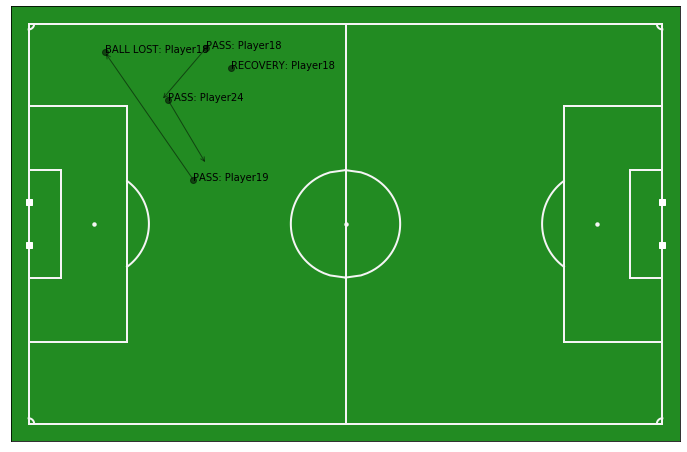

In [17]:
# plot the events
mviz.plot_events(events.loc[399:403], color='k', indicators = ['Marker','Arrow'], annotate=True )

Lets make a movie of the situation :

In [18]:
PLOTDIR = DATADIR
mviz.save_match_clip(tracking_home.iloc[29250:29250+400], tracking_away.iloc[29250:29250+400], PLOTDIR, fname='off-side')

Generating movie...done


- It is clear that the defenders use the penalty area line as a landmark to put the opponent in an off-side position. 
- They also gather in the center off the pitch. They create more spaces on the wings but less in the center: It is a choice when a team is under pressure.
- This tactic aims to reduce shots leading to goals because it is less dangerous on the wings than in the center of the pitch

Let's look at the pitch control of this situation:

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e9c75bd888>)

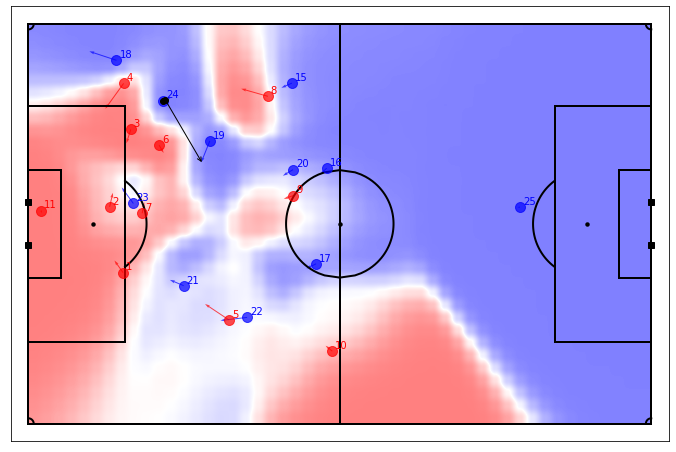

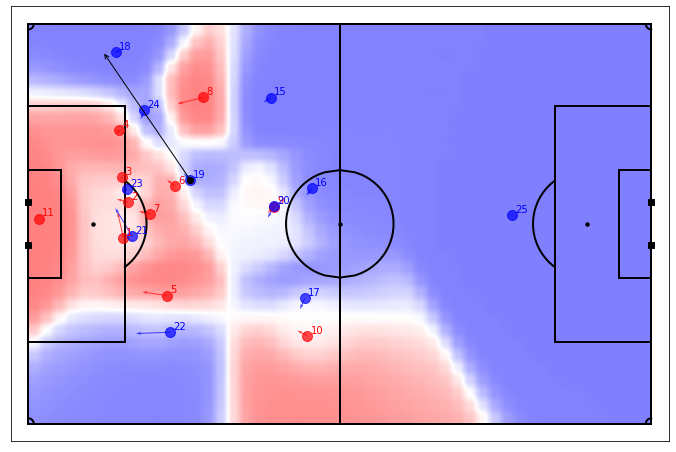

In [27]:
params = mpc.default_model_params(3)

# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(401, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 401, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )
params = mpc.default_model_params(3)

# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(402, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 402, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )

Those frames confirm that the red team try to avoid a blue player to get the control of the ball in the penalty area. The 23 blue player has much less spaces than on the previous frame but the winger has much more. It is because he is less dangerous than the striker. Moreover, the player 21 blue has arrived in the dangerous zone and so the 1 red has followed him, even if the 22 blue has more space, again he is less dangerous.

It is clearly impossible to control all of the area of the field so teams give priority to the most dangerous area. 

**What would have happened if the defenders hadn't done the move to protect the penalty area ?**

A way to explore this possibility is to give the same positions to all red players than they were at the previous time. To do so I have to fix their positions and their velocities:

In [20]:
fixed_home = tracking_home.copy()

In [23]:
for i in range(29394,29517):
    fixed_home.loc[i] =  fixed_home.loc[29394]

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e9c5cff288>)

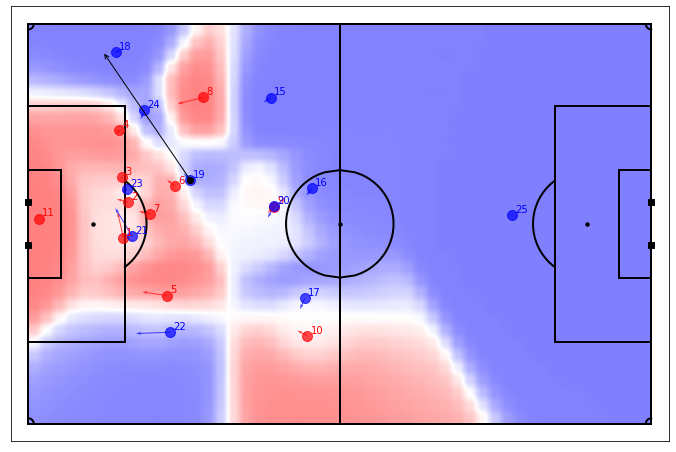

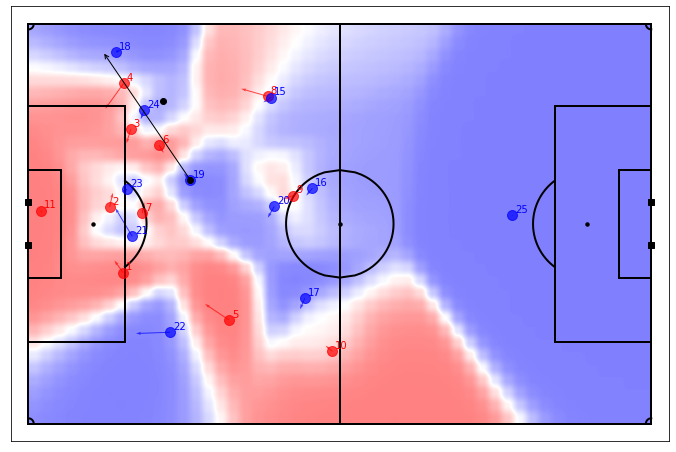

In [28]:
params = mpc.default_model_params(3)

# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(402, events, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 402, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )
params = mpc.default_model_params(3)

# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(402, events, fixed_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 402, events,  fixed_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )

The first pitch shows the real situation and the situation without the move from the home players just before the pass.

We see on the second pitch that (without any move from the defense) **spaces have been found by the strikers** (23 and 21 blue) and are in better position to score than player18. 

Even if player 18 has less chances to receive the ball, the situation is much more dangerous for the home team in red because a pass to one of the 2 strikers will bring danger directly in the penalty area.

The position of home player 5 is also interesting: he do not come back to help and so player 22 blue has open field in the center of the field, where it is very dangerous. Another message that this pitch control provide is to not forgive the defensive foreboding, even for wingers.

Finally, **the off-side is just a consequence of a mindful defense that give the priority to protect the center of the field and apply the tactic perfectly.**